# Projet  de Python pour la data science
*Nathan VAN ASSCHE et Swann-Emilien MAILLEFERT*
Ce projet a pour but de proposer er un ensemble non exhaustif d'outils pour analyser l'inflation à partir de séries macroéconomiques provenant de l'Inse
Nous montrerons que l'outil simple de la régression OLS présente des failles importantes lorsque l'on cherche mesurer les effets de co-variables du fait de la non stationnarité des données considérées. Nous proposerons plusieurs méthodes pour prendre en compte cette non stationnarité.. 


## Récupération des données
Les données sont récupérées via l'API BDM de l'Insee en utilisant le package *pynsee*. Cette opération nécessite l'initalisation d'une clé et d'un code de sécurité qui sont ensuite transmissibles à d'autres utilisateurs. Ainsi ce code est lançable depuis n'importe quelle machine sans nécessité au préalable d'avoir créé un compte sur les API Insee. On se sert ici des Idbank des séries qui peuvent être identifiées au préalable pour vos séries d'intérêt directement via le site de l'Insee https://www.insee.fr/fr/information/312853

In [6]:
##Script contient l'ensemble des installations de packages nécessaires et des fonctions de simplifications du code
!pip install pynsee
!pip install openpyxl
##Installation des packages nécessaires pour l'analyse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.stattools import coint
import seaborn as sns
import geopandas as gpd
color_pal = sns.color_palette()

##Connexion avec l'API INSEE
from pynsee import init_conn
init_conn(insee_key='OhPJjhlU6BcU1jgxYWzIWq1RcUka', insee_secret='pjqgGXAy7co3cMD4zZ8aytN5tq4a')
from pynsee.macrodata.get_series import get_series

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 10.8 MB/s eta 0:00:00


In [7]:
##Nous avons créé une classe ProjetPython qui contient quelques fonctions de mise en forme et d'import de fichiers ainsi que certaines macro-variables 
##contenant le nom des variables communément utilisées dans les tables Insee
class ProjetPython:
    '''
    Classe qui permet de gérer l'import des données via l'API BDM INSEE en connaissant les idbank, et qui permet certaines mises au format Séries temporelles pour rendre le code moins chargé.
    '''
    def __init__(self):
        '''
        Parameters
        ----------
        self.f_time : str
        contient le nom de la variable dans les tables INSEE qui indique la période
        self.f_value : str
        contient le nom de la variable dans les tables INSEE qui indique la valeur numérique de l'indice récupéré
        self.f_value_x : str
        pour faciliter les fusions des tables Insee qui contiennent le même nom de variable
        self.f_value_y : str
        pour faciliter les fusions des tables Insee qui contiennent le même nom de variable
        '''    
                
        self.f_time="TIME_PERIOD"
        self.f_value="OBS_VALUE" 
        self.f_value_x="OBS_VALUE_x" 
        self.f_value_y="OBS_VALUE_y" 
                
    def import1(self,idbank):
        '''
        Méthode qui permet d'importer des données directement depuis l'API Insee en connaissant l'Idbank de la série avec quelques étapes de mise en forme (sélection des colonnes, et mise au format Séries Temporelles)

        
        Parameters
        ----------
        idbank : str
        l'IDBANK correspondant à la série que l'on souhaite importer (à identifier directement sur le site de l'INSEE
        '''    
        df_init = get_series(idbank)
        df = df_init.loc[:,['TIME_PERIOD','OBS_VALUE']]
        df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])
        df.set_index('TIME_PERIOD',inplace=True)
        return df
        
    def import2(self,idbank,name):
        '''
        Méthode qui permet d'importer des données directement depuis l'API Insee en connaissant l'Idbank de la série avec quelques étapes de mise en forme (sélection des colonnes, et mise au format Séries Temporelles)

        
        Parameters
        ----------
        idbank : str
        l'IDBANK correspondant à la série que l'on souhaite importer (à identifier directement sur le site de l'INSEE
        name : str
        Le nom de la série considéré (pour les affichages graphiques)
        '''    
        df_init = get_series(idbank)
        df = df_init.loc[:,['TIME_PERIOD','OBS_VALUE']]
        df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'])
        df.set_index('TIME_PERIOD',inplace=True)
        df["Series"]=name
        return df

    def sub_rename(self,df,time,name):
        '''
        Méthode de mise en forme de data_frame, qui réduit la plage temporelle considéré et renomme la colonne contenant les valeurs numériques de l'indice avec le nom souhaité
        
        Parameters
        ----------
        df : DataFrame
        Le DataFrame que l'on souhiate modifier
        time : str
        La date à partir de laquelle on travaille
        name : str
        Le nom souhaité pour la colonne contenant les valeurs (pour les affichages graphiques)
        '''
        df = df[df.index>time]
        df = df.rename(columns={'OBS_VALUE': name})
        return df

In [54]:
pp = ProjetPython()

Nous allons aussi nous intéresser à différentes données sur l'inflation issues d'Eurostats, nous avons donc aussi réalisé une classe Eurostats pour généraliser l'ouverture et la manipulation des fichiers excel issus de ce site.

In [22]:
class Eurostats:
    '''
    Classe qui permet la modélisation de données issues de Eurostats, il faut seulement donner en entrée le nom par lequel vous avez appelé le fichier que vous importez.
    
    '''
    def __init__(self, path):
        """
        Parameters
        ----------
        self.excel_name : str
            Nom du fichier excel à importer
        self.sheet_sheet : str
            
        self.skip_rows : int
            Nombre de lignes qu'on doit ignorer pour que le dataframe commence au bon endroit
        self.dataframe : dataframe pandas
            Le dataframe qu'on va utiliser pour l'analyse des données, il est initialement vide et sera mis à jour à l'aide des méthode import et nettoyage.
        self.timeserie : dataframe pandas
            Série temporelle pour un pays considéré qu'on initialise vide mais qui sera sélectionné avec la méthode time_serie
        """

        self.excel_name = path
        self.sheet = 1
        self.skip_rows = 8
        self.dataframe = pd.DataFrame()
        self.timeserie = pd.DataFrame
        self.paysts = ''
    def imp(self):
        '''
        Méthode qui permet l'import des données excel via la fonction pandas read_excel
        '''
        self.dataframe = pd.read_excel(f"Data/{self.excel_name}.xlsx", sheet_name=f"Sheet {self.sheet}", skiprows=self.skip_rows)
    def nettoyage(self):
        '''
        Méthode qui permet de rendre le jeu de données utilisable. Elle permet de sélectionner le pays d'intérêt, et transforme le dataframe en une série temporelle ayant pour index le temps
        pour les données du pays considéré.
        
        '''
        self.dataframe = self.dataframe.loc[:, ~self.dataframe.columns.str.startswith('Unnamed')]
        self.dataframe = self.dataframe.iloc[1:-6]
        self.dataframe.replace(":", np.nan, inplace=True)
        

    def carte(self, date):
        '''
        On réalise une carte de l'Europe pour la donnée considérée et la date choisie.

        Parameters
        ----------
        date : date (format 'YYYY-MM')
            Date correspondant au moment choisi pour faire la carte. 
        '''
        bbox = Polygon([[-32.800788, 33.886212],
                            [35.324212,33.886212],
                            [35.324212,71.763749],
                            [-32.800788, 71.763749]])
        bbox_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry = [bbox])
        europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        europe = europe[europe.continent == 'Europe']
        europe = europe.overlay(bbox_gdf, how="intersection")
        merged_data = europe.merge(self.dataframe, how='left', left_on='name', right_on='TIME')
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        merged_data.plot(column=date, cmap='inferno', linewidth=0.8, ax=ax, edgecolor='0.5', legend=True)
        merged_data[merged_data[date].isna()].plot(ax=ax, color='grey', hatch='//', edgecolor='0.8')
        for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data[date]):
            if np.isnan(label):
                ax.text(x, y, 'Missing', fontsize=5, ha='center', va='center', color='black', fontweight='bold')
            else:
                ax.text(x, y, f'{label:.2f}', fontsize=7, ha='center', va='center', color='green', fontweight='bold')
        ax.set_title(f'IPCH des différents pays européens en {date}')
        ax.set_axis_off()
        legend = ax.get_legend()
        legend
        plt.show()

        
    def time_serie(self, pays):
        '''
        On actualise la valeur self.time_serie en lui associant la série temporelle correspondant au pays choisi.
        Parameters
        ----------
        pays : str
            Le pays pour lequel on veut utiliser les données considérées.
            
        '''
        self.paysts = pays
        self.timeserie = self.dataframe[self.dataframe.iloc[:, 0].str.startswith(pays)]
        self.timeserie = self.timeserie.iloc[:, 1:]
        self.timeserie = self.timeserie.T
        self.timeserie.columns = ['Prix']
        self.timeserie.index = pd.to_datetime(self.timeserie.index, format='%Y-%m')
    def regression(self):
        '''
        Méthode qui permet sur la série temporelle considérée d'afficher dans un graphique les données de la série au cours du temps ainsi que la droite de régression associée
        '''
        self.timeserie = self.timeserie.dropna(subset=['Prix'])
        # Scale the time index
        self.timeserie['scaled_time'] = (self.timeserie.index - self.timeserie.index[0]).days
        
        # Perform regression
        X = sm.add_constant(self.timeserie['scaled_time'])
        y = self.timeserie['Prix']
        model = sm.OLS(y, X).fit()
        coeff = model.params['scaled_time'] 
        # Plot the data and regression line
        plt.plot(self.timeserie.index, y, label=f'{self.paysts}', linestyle='-', color='blue')
        plt.plot(self.timeserie.index, model.predict(X), label='Droite de régression', color='red')
        plt.xlabel('Temps')
        plt.ylabel('Prix')
        plt.title(f'Régression du niveau de {self.excel_name} sur le temps')
        plt.legend()
        plt.show()
        print(f'Le coefficient de la régression est {coeff}.')

Les données d'Eurostats sont des données issues des différents pays européens. Nous allons dans un premier temps nous intéresser à l'IPCH, l'Indice des prix à la consommation harmonisé. Cet indice permet de comparer l'inflation des différents pays selon des critères établis. C'est un indicateur de stabilité des prix. Nous allons donc importer le jeu de données de l'IPCH d'Eurostats à l'aide des méthodes de classe éponyme. La méthode nettoyage rend le jeu de données utilisable pour de la visualisation a posteriori.

In [23]:
data = Eurostats('IPCH')
data.imp()
data.nettoyage()

/opt/mamba/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Pour avoir une première vision globale de l'inflation à travers cet indicateur, nous allons le comparer entre les différents pays à deux dates données pour voir l'évolution. La palette de couleur utilisée pour cette cartographie est l'option 'inferno' de 'viridis' qui est une palette de couleur plus accessible pour les populations daltoniennes par exemple. De plus, les valeurs de la variable expliquée sur cette cartographie sont rajoutées sur les pays pour encore une fois faciliter l'accès aux malvoyants.

/tmp/ipykernel_211/2038805757.py:57: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed
/tmp/ipykernel_211/2038805757.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data[date]):


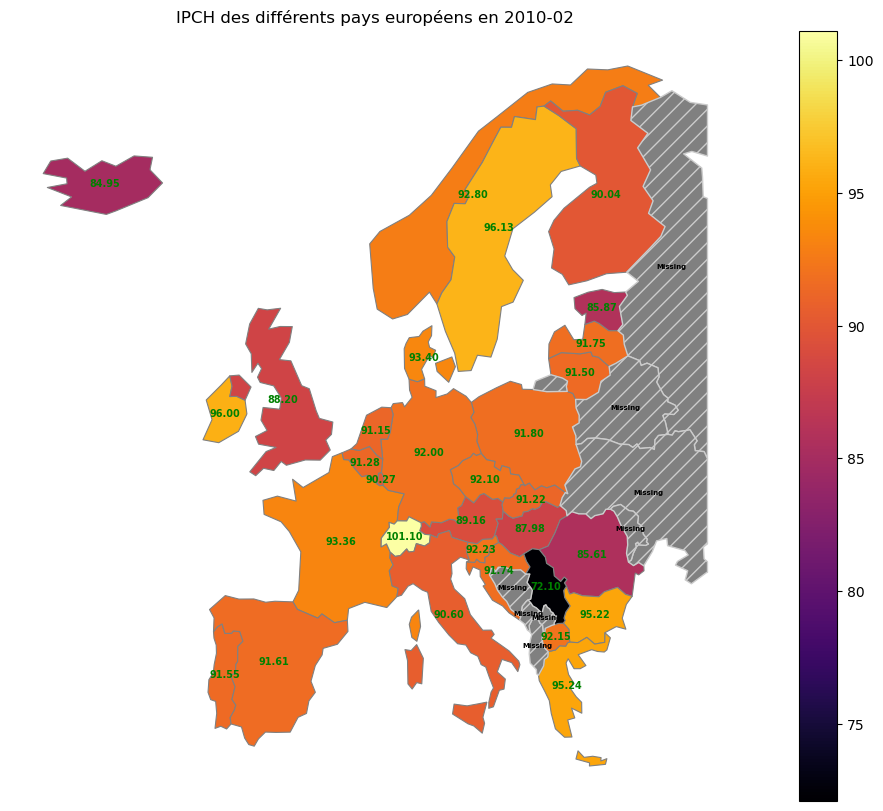

In [10]:
data.carte('2010-02')

Comme nous pouvons le voir sur cette carte, l'inflation est quasiment à un niveau similaire dans tous les pays européens à l'exception de pays comme la Suisse qui ont une inflation légèrement supérieure au reste de l'Europe ou alors de la Servie ou encore la Roumanie qui ont une inflation inférieure au reste des pays.

/tmp/ipykernel_211/2038805757.py:57: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_211/2038805757.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged_data.geometry.centroid.x, merged_data.geometry.centroid.y, merged_data[date]):


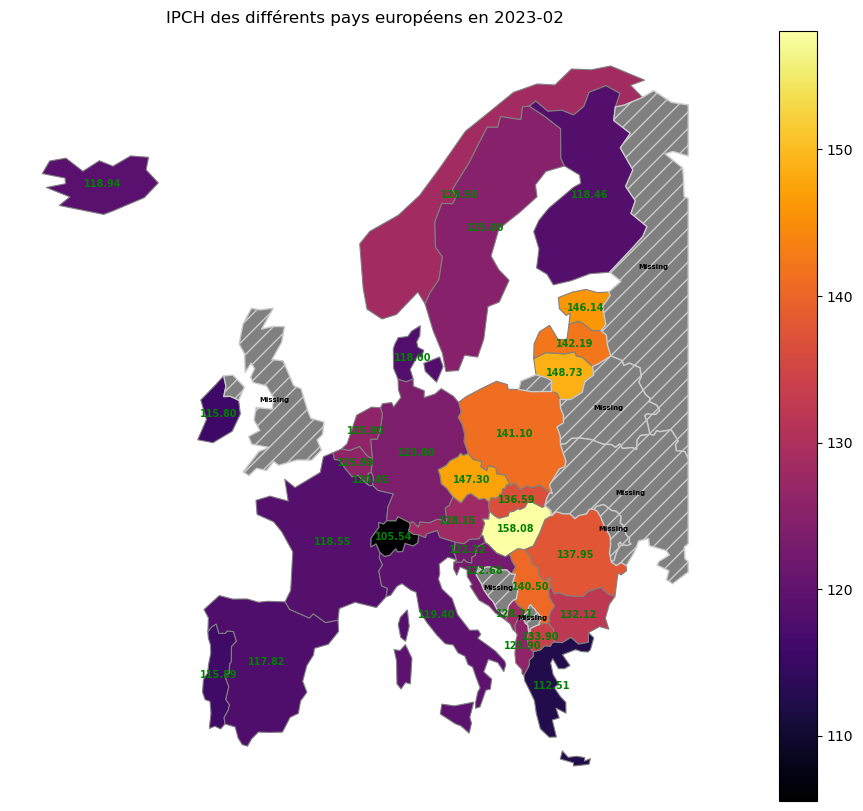

In [11]:
data.carte('2023-02')

Cette fois-ci, l'inflation observée est bien moins uniforme qu'auparavant, les pays de l'Europe de l'Ouest semble toujours avoir un niveau similaire d'inflation relative, en revanche en europe de l'Est, là où se trouvait l'inflation la plus faible relativement au reste de l'Europe se trouve maintenant une inflation beaucoup plus importante que sur le reste du territoire européen.

Nous allons donc nous intéresser à l'évolution du niveau de l'IPCH pour la France mais aussi pour les pays évoqués précédemment à titre de comparaison.

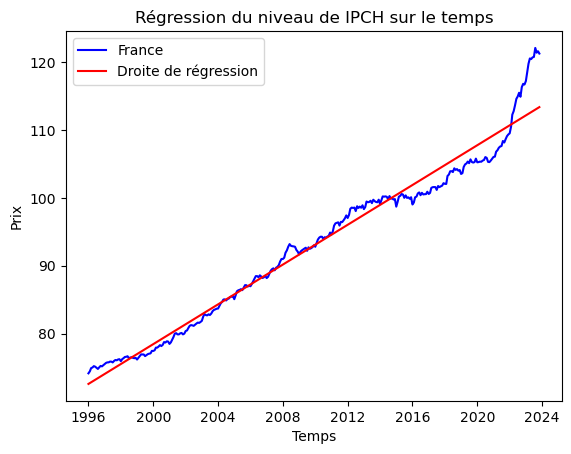

Le coefficient de la régression est 0.004013825667932706.


In [24]:
data.time_serie('France')
data.regression()

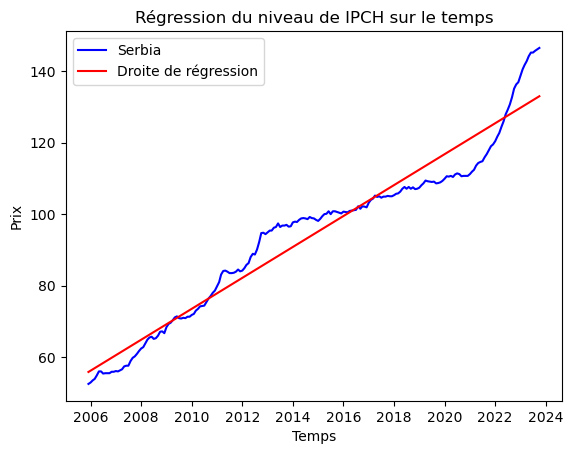

Le coefficient de la régression est 0.01184365613386691.


In [25]:
data.time_serie('Serbia')
data.regression()

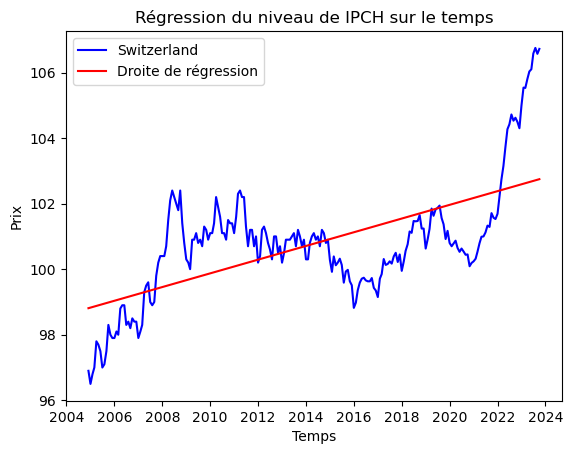

Le coefficient de la régression est 0.0005721869254720121.


In [26]:
data.time_serie('Switzerland')
data.regression()

Comme nous pouvons le constater, le coefficient de la droite de régression de la Serbie est environ 2.5 fois plus important que celui de la France, qui est lui même environ 10 fois plus important que celui de la Suisse, cela dit l'IPCH de la suisse ne varie pas de manière quasi-linéaire comme le font celui de la France et de la Serbie donc ce coefficient est moins interprétable. Cela-dit, ces résultats corroborent la première analyse faite sur les cartes. Les pays de l'Europe connaissent une certaine inflation mais l'importance de celle-ci est différente en fonction de la région où l'on se trouve, avec de très fortes augmentations en Europe de l'Est par exemple.

Nous allons désormais nous intéresser à une gamme de produit en particulier, les fruits. Leurs prix est une variable pour la construction de l'IPCH.

In [30]:
fruit = Eurostats('fruit')
fruit.imp()
fruit.nettoyage()

/opt/mamba/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Nous allons surtout nous intéresser à l'évolution de cet indice de prix en France

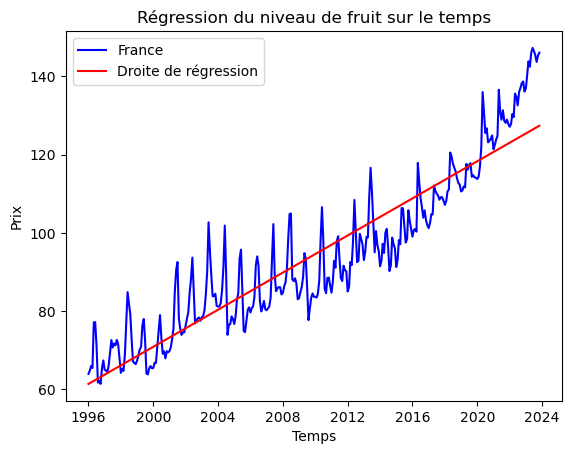

Le coefficient de la régression est 0.006495716536080675.


In [32]:
fruit.time_serie('France')
fruit.regression()

Comme nous pouvons le constater, cette série est loins d'être linéaire et possède de nombreuses périodes oscillations.

Nous allons donc nous intéresser à la distribution de cet indice en fonction des différents mois de l'année. En effet

/tmp/ipykernel_211/863106627.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='Prix', data=st,palette=sns.color_palette('muted', 12))


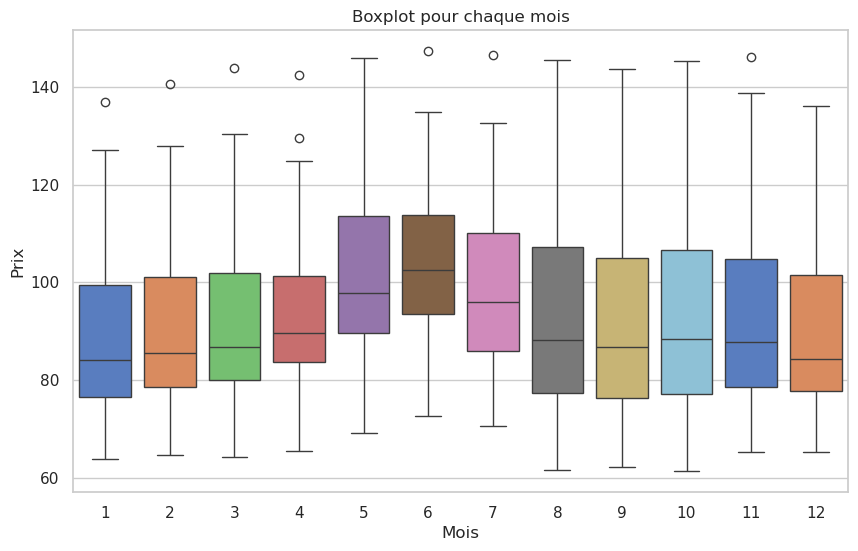

In [41]:
st = fruit.timeserie
st.index = pd.to_datetime(st.index, format='%Y-%m')
st['month'] = st.index.month

# Créez un boxplot avec seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='Prix', data=st,palette=sns.color_palette('muted', 12))
plt.title('Boxplot pour chaque mois')
plt.xlabel('Mois')
plt.ylabel('Prix')
plt.show()


/tmp/ipykernel_211/611812346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='Prix', data=df_filtered,palette=sns.color_palette('muted', 12))


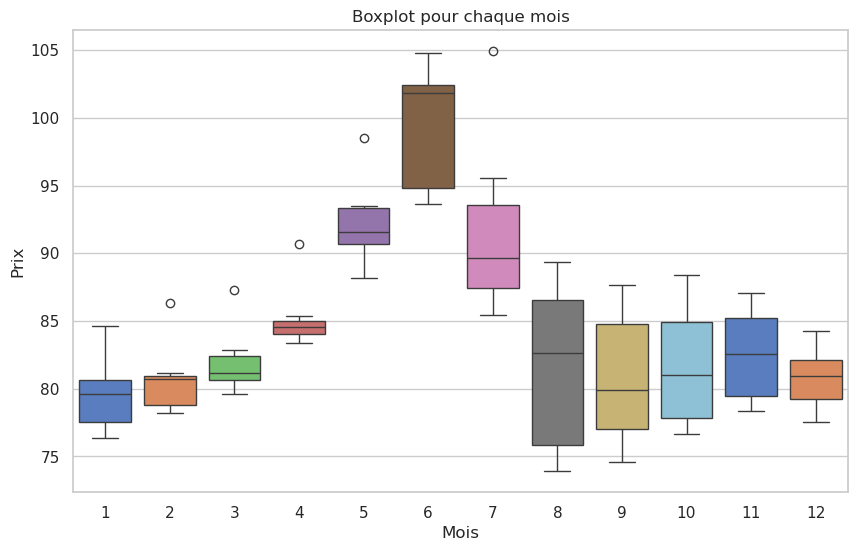

In [43]:
# Créez un boxplot avec seaborn
df_filtered = st['2002-01-01':'2008-12-01']
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='Prix', data=df_filtered,palette=sns.color_palette('muted', 12))
plt.title('Boxplot pour chaque mois')
plt.xlabel('Mois')
plt.ylabel('Prix')
plt.show()

## Régressions fallacieuses et premières analyses de séries macro-économiques INSEE
Après s'être intéressé à quelques outils de data-visualisation applicables aux séries temporelles, nous allons montrer que régresser des séries directement sans transformation mène souvent à une régression de mauvaise qualité lorsque l'on s'intéresse aux résidus de la régression.
Nous chercherons dans cette première partie à voir le lien entre les prix d'importation de l'énergie et les prix de production.

In [55]:
#On récupère les prix à l'importation de l'énergie via l'API et idem pour l'Indice des Prix de Production total Industrie
energie_prix_import = pp.import1('010535859')
IPP_tot = pp.import1('010535587')

Comme pour toute série temporelle, il est possible de réaliser une décomposition entre tendance, saisonnalité et résidus au moyen de moyennes mobiles de façon à identifier assez rapidement d'ou proviennent les évolutions observées. Cela donne en première analyse les grandes tendances d'évolution des grandeurs macro-économiques considérées et peut aussi donner une idée des chocs qui ont pu impacter la série, ce qui est notamment visible au niveau du processus résiduel et des changements de tendance.

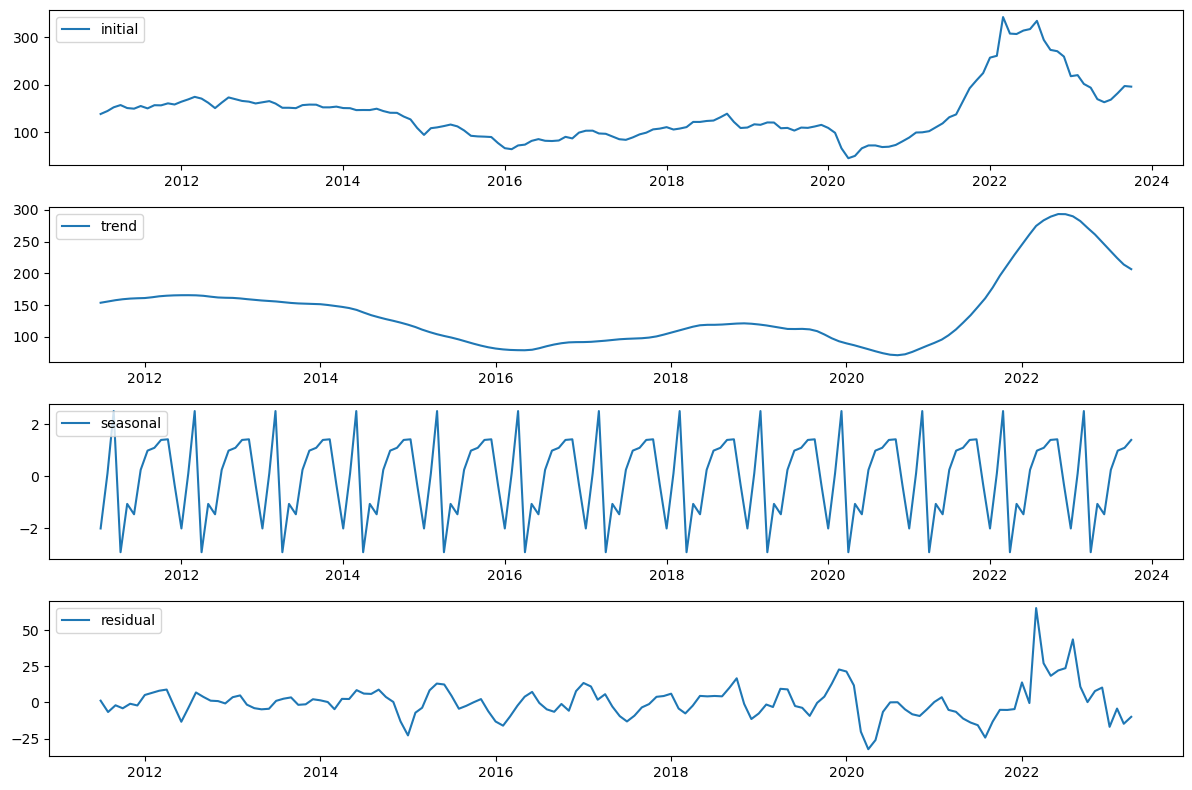

In [56]:
##On supprime toutes les méta-données non utiles pour l'analyse et on passe en index la période pour travailler avec des outils de Séries Temporelles
##Tout d'abord pour la série des prix de l'énergie
result = seasonal_decompose(energie_prix_import,model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid
##Affichage graphique de la décomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(energie_prix_import, label="initial")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

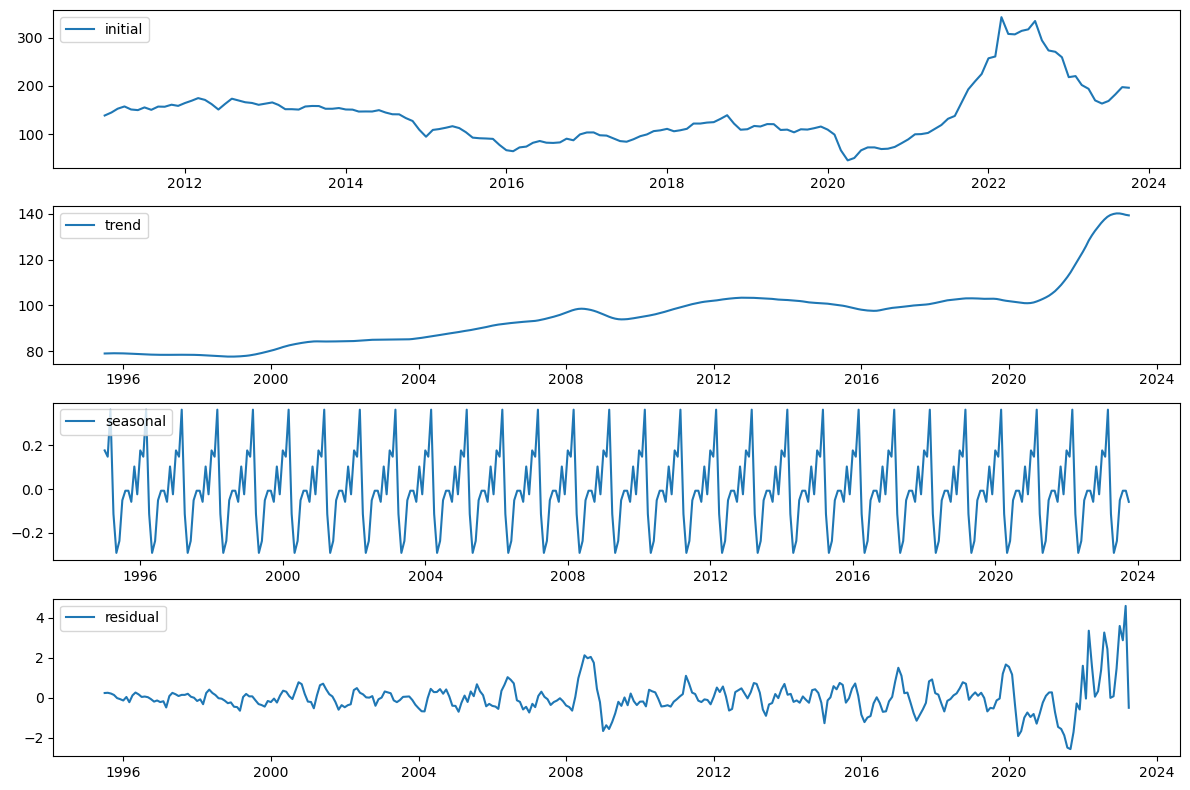

In [57]:
##On transforme également IPP et IPC en séries temporelles IPP
result = seasonal_decompose(IPP_tot,model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid
##Affichage graphique de la décomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(energie_prix_import, label="initial")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

On peut déjà observer que le processus résiduel présente des valeurs beaucoup plus importantes aux alentours des crises économiques (2008 et 2019-), l'idée sera que les modèles économétriques seront mis à mal durant les temps de crise et on verra qu'introduire une modélisation avec une équation de long terme et une équation de court terme prenant compte de l'ajustement vis-à-vis de cette équation de long terme (on parlera de modèles à correction d'erreur) permettra de mieux prendre en compte les effets des crises lorsque l'on cherchera à régresser des séries entre elles.


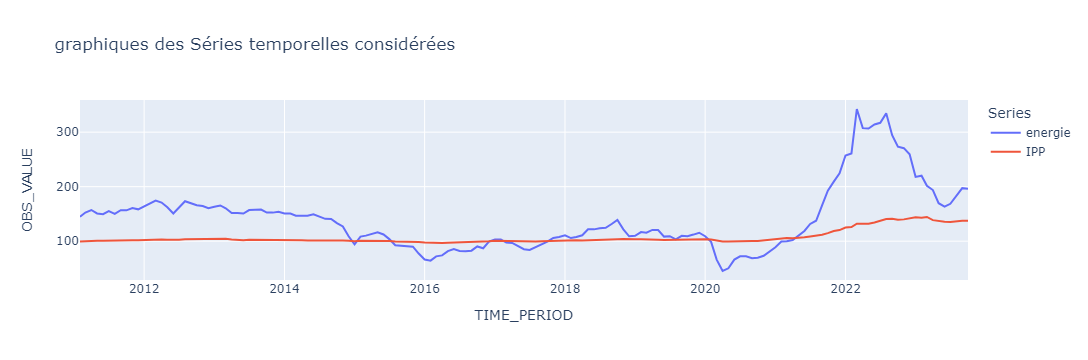

In [59]:
##Visuellement, est-ce qu'on observe un lien entre ces 2 séries?
energie_prix_import["Series"]="energie"
IPP_tot["Series"]="IPP"
data_plot = pd.concat([energie_prix_import,IPP_tot])
data_plot = data_plot[data_plot.index>"2011-01-31"]
fig = px.line(data_plot, x=data_plot.index, y=pp.f_value, color='Series', title = "graphiques des Séries temporelles considérées", hover_data={pp.f_value:':.2f'})
fig.show()

<Figure size 2500x2500 with 0 Axes>

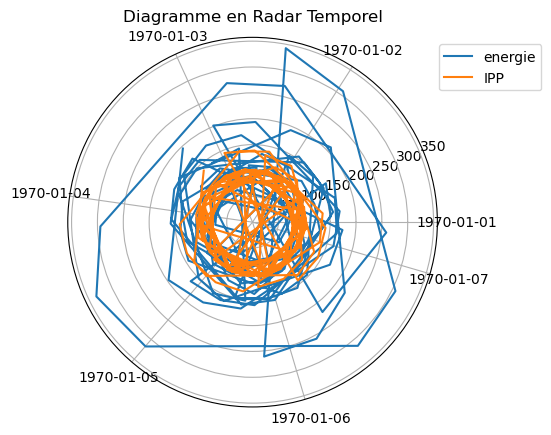

In [61]:
##diagramme en radar temporel
data = pd.merge(energie_prix_import.drop(columns=['Series']),IPP_tot.drop(columns=['Series']), on=pp.f_time, how="inner")
data_sub = data[(data.index>="2015-01-01")]
plt.figure(figsize=(25,25))
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(data[pp.f_value_x], label='energie')
ax.plot(data[pp.f_value_y], label='IPP')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Diagramme en Radar Temporel')
plt.show()
###La très forte volatilité des séries de l'énergie comparé à IPP laisse à penser que la régression ne donnera pas de résultats trop significatifs

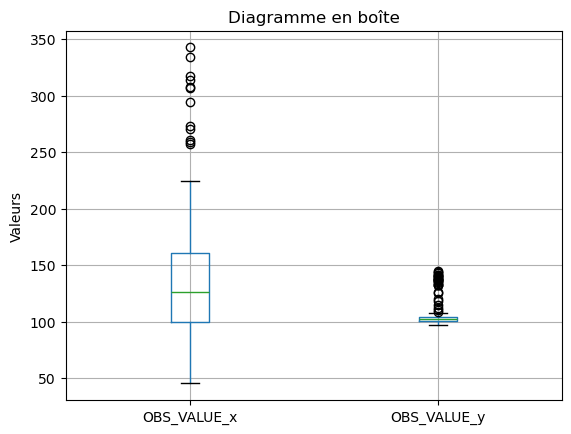

In [62]:
#On peut tirer les mêmes conclusions d'un diagramme en boîte temporel
fig, ax = plt.subplots()
data.boxplot(ax=ax)
ax.set_ylabel('Valeurs')
plt.title('Diagramme en boîte')
plt.show()

#### Notion de non stationnarité
> Une série $X_{t}$ est dite stationnaire si ses deux premiers moments, à savoir son espérance $\mu_{t}$ = E($X_{t}$) et les autocovariances $\gamma_{tk}$ = cov($X_{t}$, $X_{k}$), sont finies et indépendantes du temps.
Visuellement une telle série tend à retourner à sa moyenne quand elle s'en est écartée sous l'effet de chocs.

> La principale forme de non-stationnarité est due à la présence d'une tendance, et là deux cas sont à distinguer :
    - Il peut exister une tendance déterministe dans le processus, qui s'écrit alors sous la forme $X_t = a*t + \epsilon_t$ ; on parle de modèle trend-stationnaire.
    - Ou alors on peut observer une tendance stochastique due à la présence d'une racine unitaire, par exemple le processus $X_t = X_{t-1} + \epsilon_t$.
La différence principale entre ces deux types de tendances réside dans la persistance des chocs. Pour les trend-stationnaires, les chocs s'estompent (forme de retour à la moyenne) alors que pour les racines unitaires les chocs sont permanents et il est donc impossible de proposer des prévisions fiables.

> Il est important de souligner que les techniques générales d'inférence statistique ne fonctionnent plus de façon usuelle quand les séries considérées sont non-stationnaires. En particulier l'estimateur des coefficients est super-convergent (vitesse de convergence en 1/T au lieu de l'habituelle $\sqrt{T}$, de plus on n'a plus l'habituelle convergence de l'écart entre l'estimateur et la vraie valeur vers une loi normale). De ce fait, les tests usuels de Student ne sont plus valides puisque ce n'est plus la même loi asymptotique. On ne peut régresser une série non stationnaire sur une autre série non stationnaire que s'il existe une combinaison linéaire des deux séries qui, elle, est stationnaire (on dit alors que les séries sont co-intégrées).

Afin de stationnariser les séries, on peut travailler avec les différences du premier ordre des séries.

In [65]:
##Test de stationnarité des séries temporelles
energy_adf = adfuller(energie_prix_import.drop(columns=['Series']))
print('p-value',energy_adf[1])
IPP_tot_adf = adfuller(IPP_tot.drop(columns=['Series']))
print('p-value',IPP_tot_adf[1])
##On ne peut nulle part rejeter l'hypothèse nulle de non stationnarité, il faudra donc différencier les séries avant de faire les régressions

p-value 0.5940022688622959
p-value 0.9965016782275393


In [66]:
###Montrons les défauts de passer par une simple régression OLS
data = pd.merge(energie_prix_import.drop(columns=['Series']),IPP_tot.drop(columns=['Series']), on=pp.f_time, how="inner")
##Simple régression OLS
X = sm.add_constant(data[[pp.f_value_x]])
y = data[pp.f_value_y]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

##Comme la variable endogène n'est pas présente avec retard, on peut tester l'autocorrélation des résidus directement avec le test de Durbin-Watson
##le summary nous donne une valeur de 0.047, or pour que les résidus ne soient pas auto-corrélés à l'ordre 1, DW doit être proche de 2 (en pratique
##on accepte des modèle avec DW entre 1.5 et 2.5
##pour afficher directement la stat DW : 
DW_stat = durbin_watson(results.resid)
print("La statistique de test de Durbin Watson a pour valeur : ",DW_stat)
##Ainsi, on rejette déjà l'hypothèse de non autocorrélation des résidus, les résultats de la régression ne sont donc pas interprétables tels quels

##test d'homoscédasticité des résidus par le test de White
from statsmodels.stats.diagnostic import het_white
white_test = het_white(results.resid,X)
print("p-valeur du test de White : ",white_test[1])
##On rejette l'hypothèse d'homoscédasticité des résidus (p-valeur < 5%)

##Test de normalité des résidus (test de Jarque-Bera)
from scipy.stats import jarque_bera
jb_stat, p_value_JB = jarque_bera(results.resid)
print("p-valeur du test de Jarque-Bera : ",p_value_JB)
##On rejette l'hypothèse nulle de normalité des résidus

##Donc une régression simple n'est pas interprétable dans ces conditions
##Ainsi, malgré un R2 très élevé (0.63) et la significativité des coefficients (d'après les tests usuels), la régression est fallacieuse du fait 
##de la non stationnarité des séries, comme peuvent en témoigner les différents tests statistiques réalisés

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     256.8
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.81e-34
Time:                        07:58:26   Log-Likelihood:                -533.72
No. Observations:                 154   AIC:                             1071.
Df Residuals:                     152   BIC:                             1078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.0396      1.622     51.190      

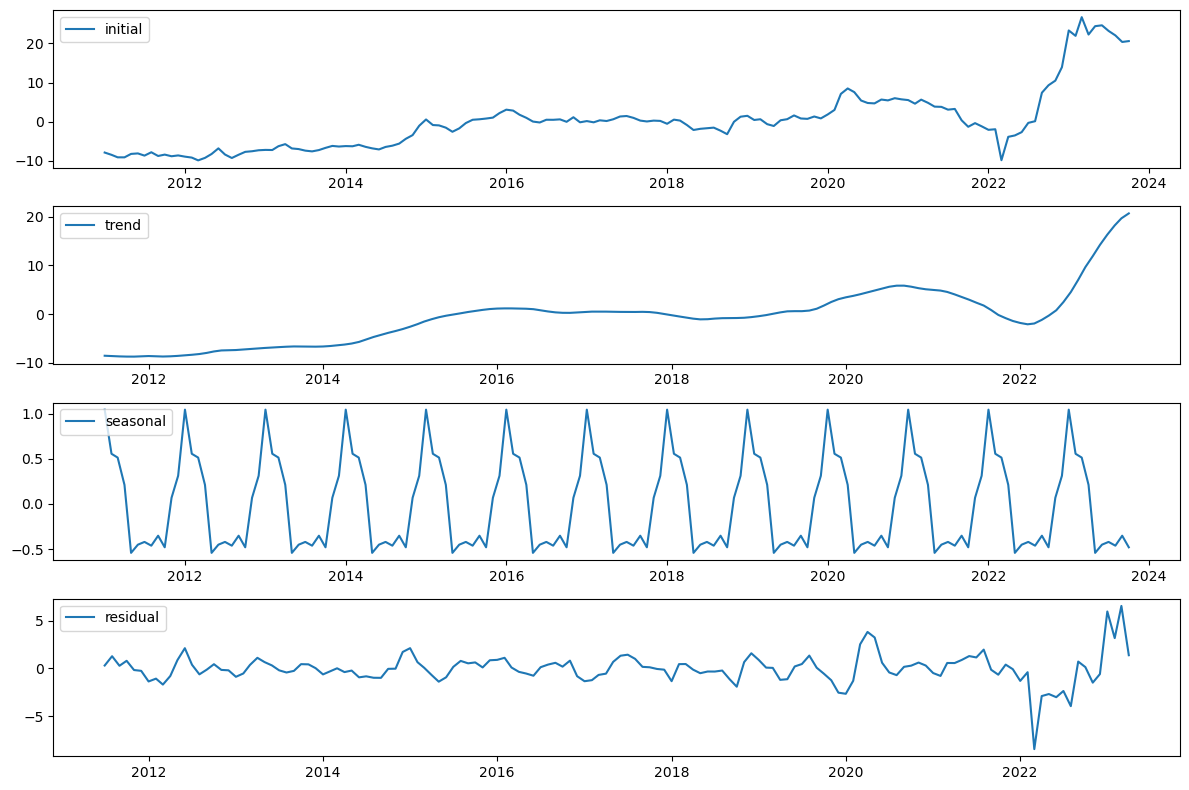

In [71]:
##Si on cherche à réaliser une décomposition tendance/saisonnalité/résidu sur justement le processus résiduel de la régression, on observe le résultat suivant : 
result = seasonal_decompose(results.resid,model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid
##Affichage graphique de la décomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(results.resid, label="initial")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label="seasonal")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


##On peut clairement voir apparaître une forte tendance dans le processus résiduel, ce qui vient illustrer la non- stationnarité de ce dernier

In [72]:
##Si on travaille avec des séries différenciées
##On différencie les données pour travailler avec des séries stationnaires
data_diff = data.diff().dropna()
energy_adf = adfuller(data_diff[pp.f_value_x])
IPP_adf = adfuller(data_diff[pp.f_value_y])
print('p-value',energy_adf[1])
print('p-value',IPP_adf[1])
##Les test de stationnarité rejettent l'hypothèse nulle de non stationnarité des séries utilisées (au pire au seuil de 7%)
##On crée les valeurs lag des observations qui serviront de variables au modèle
lag_x = data_diff[pp.f_value_x].shift(1)
lag_y = data_diff[pp.f_value_y].shift(1)
data_diff['lag_x'] = lag_x
data_diff['lag_y'] = lag_y
data_diff = data_diff.dropna()
##Modelisation
X = sm.add_constant(data_diff[['lag_x']])
y = data_diff['lag_y']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

##Le test de Durbin Watson nous permet de conclure à l'absence d'autocorrélation dans le processus résiduel, ce qui rend la régression interprétable.
##Dans l'exemple ici, on ne pourra travailler qu'avec des régressions en différences du premier ordre de façon à stationnariser les séries.

p-value 0.00047347931334817793
p-value 0.06460233430678242
                            OLS Regression Results                            
Dep. Variable:                  lag_y   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     92.68
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.22e-17
Time:                        08:04:33   Log-Likelihood:                -202.83
No. Observations:                 152   AIC:                             409.7
Df Residuals:                     150   BIC:                             415.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

## Modélisation ECM (Error Correction Model)
Il est tout de même possible de régresser des séries non stationnaires entre elles, mais uniquement dans un contexte particulier de séries co-intégrées ; autrement dit s'il existe une combinaison linéaire de ces séries non stationnaires donnant lieu à un processus stationnaire. Cette combinaison linéaire correspond à l'équation de long terme du **modèle ECM (Error Correction Model)**. Cette équation sert à définir une relation d'équilibre. Le résidu issu de celle-ci définit donc une distance à l'équilibre. Le modèle ECM repose sur une seconde équation de court terme qui utilise les variables en variation et le résidu retardé de l'équation de long terme. Dans cette seconde équation, les séries considérées sont stationnaires, ce qui évite les problèmes de régression fallacieuse et permet de définir avec le résidu une force de rappel pour ramener le système à la situation d'équilibre. Ainsi, une modélisation ECM permet de capter les phénomènes de rattrapages ayant lieu après de fortes crises/expansions.

Afin de réduire le biais d'estimation propre à l'équation de long terme, on utilise la **méthode d'estimation de Stock et Watson** consistant à introduire des variations avancées et retardées des variables explicatives.
Pour tester l'existence d'une relation de co-intégration, on peut utiliser le test de Johansen basé sur la statistique de la trace, d'hypothèse nulle l'absence de relation de co-intégration, ou le test de co-intégration de Phillips-Ouliaris d'hypothèse nulle la non co-intégration de la matrice des variableées.

L'équation de long terme doit conduire à une relation de co-intégration (combinaison linéaire stationnaire de séries intégrées d'ordre 1), impliquant notamment que les résidus doivent être stationnaires, ce qui va permettre de rendre compte de la qualité du modèle. Concernant l'équation de court terme, il est nécessaire d'obtenir un résidu homoscédastique et non auto-corrélé (bruit b.tt**.


In [73]:
##Modele à Correction d'Erreur
##Equation de long terme
long_terme = sm.OLS(data[pp.f_value_y], sm.add_constant(data[[pp.f_value_x]])).fit()
print(long_terme.summary())
residus = long_terme.resid
##On récupère le résidu qu'on introduit comme une variable explicative dans l'équation de court terme

##Equation de court terme
residus_lag = pd.Series(residus.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on=pp.f_time, how="inner")
court_terme = sm.OLS(data_courte[pp.f_value_y], sm.add_constant(data_courte[[pp.f_value_x,'residus']])).fit()
print(court_terme.summary())
##Le coefficient devant le residu issu de la première étape peut s'interpréter comme une vitesse de convergence, il est bien négatif comme attendu
##Ici il vaut 1,4%, ce qui signifie qu'à chaque mois, la variable y comble 1,4% de l'écart à sa valeur de long terme 
##(attention ici on a peu de variables explicatives pour réaliser l'équation de long terme)
##En l'absence de chocs consécutifs, il faudrait donc 100/1.4 = 71 mois soit environ 6 ans pour un retour à l'équilibre

##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
##Problème, on a un résidu non stationnaire, de ce fait, le modèle ECM est de mauvaise qualité
##De plus, dans ce contexte de modèle ECM, aucune loi n'est connue pour les estimateurs, il est donc impossible d'interpréter les tests statistiques sur les coefficients

##On retiendra de cette exemple surtout la théorie et la mise en pratique sur un cas simple de la méthode d'estimation par Error Correction Model

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     256.8
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.81e-34
Time:                        08:05:44   Log-Likelihood:                -533.72
No. Observations:                 154   AIC:                             1071.
Df Residuals:                     152   BIC:                             1078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.0396      1.622     51.190      

In [74]:
##Pour limiter le biais introduit à la première étape, Stock et Watson propose des dynamic OLS, où on introduit symétriquement des variations avance et retard dans la première étape
##On va donc créer dans un premier temps les variables avance et retard de la variable explicative
data = pd.merge(energie_prix_import,IPP_tot, on=pp.f_time, how="inner")
nombre_retard = 2
for i in range(1,nombre_retard+1):
    data[f'Delta_X_lag_{i}'] = data[pp.f_value_x]-data[pp.f_value_x].shift(i)
    data[f'Delta_X_lead_{i}'] = data[pp.f_value_x]-data[pp.f_value_x].shift(-i)
data = data.dropna()

##Equation de long terme, dans laquelle on a inclu les variables précédemment créées
long_terme = sm.OLS(data[pp.f_value_y], sm.add_constant(data[[pp.f_value_x,'Delta_X_lag_1','Delta_X_lag_2','Delta_X_lead_1','Delta_X_lead_2']])).fit()
print(long_terme.summary())
residus = long_terme.resid
##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
###Attention, le processus résiduel n'est toujours pas stationnaire, nous ne pouvons donc pas interpréter les coefficients

##Equation de court terme
##Attention il faut un peu transformer le résidu avant de l'introduire dans l'équation de court terme, on calcule le résidu en enlevant seulement l'effet de la variable explicative,
##on exclut les effets des variations avance et retard
residus_trans = data[pp.f_value_y]-long_terme.params[pp.f_value_x]*data[pp.f_value_x]-long_terme.params['const']
residus_lag = pd.Series(residus_trans.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on=pp.f_time, how="inner")
court_terme = sm.OLS(data_courte[pp.f_value_y], sm.add_constant(data_courte[[pp.f_value_x,'residus']])).fit()
print(court_terme.summary())
##On passe de 1,4% à 1,7% pour la force de rappel, pas de grande différence

##De toute façon, le résidu de première étpae n'étant pas stationnaire, il n'est pas possible en l'état d'interpréter les coefficients obtenus. 
##Cet exemple vise surtout à familiariser l'utilisateur avec les concepts propres aux Error Correction Models
##qui seront ensuite mis en pratique sur un exemple plus complexe et plus instructif ci-après.

                            OLS Regression Results                            
Dep. Variable:            OBS_VALUE_y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     62.65
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.00e-34
Time:                        08:06:35   Log-Likelihood:                -503.16
No. Observations:                 150   AIC:                             1018.
Df Residuals:                     144   BIC:                             1036.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             82.2206      1.522     54.

In [75]:
#####Pourquoi n'obtient-on pas une équation de long terme avec un résidu stationnaire?
##Si on réalise le test de co-intégration pour tester si il existe une relation entre nos 2 séries de façon à obtenir un  résidu stationnaire, le test de Johansen ne permet  pas de 
#rejeter l'hypothèse nulle de non co-intégration, de ce fait on ne pourra pas trouver une relation de long terme pour le modèle ECM
test_coint = coint(data[pp.f_value_x],data[pp.f_value_y])
print("p-valeur du test de co-intégration : ", test_coint[1]) 

p-valeur du test de co-intégration :  0.3443460269505713


## Nouvel exemple 
La partie précédente a surtout permis d'introduire les différents concepts et de familiariser l'utilisateur avec le code nécessaire pour la mise en place d'un modèle ECM.

Dans cette partie nous cherchons à identifier, pour le prix de production des voitures en France, l'impact des variations des prix des matières premières les plus utilisées dans la conception automobile. 
Nous partirons sur une modélisation par ECM qui cette fois présentera une équation de long terme avec un résidu stationnaire.
Plus précisément, nous comparerons la régression obtenue juste en stationnarisant les séries (par différence de premier ordre) avec l'équation de court terme d'un modèle ECM (qui de fait introduit une force de rappel), et nous comparerons les contributions des différentes variables.

1/1 - Getting series: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


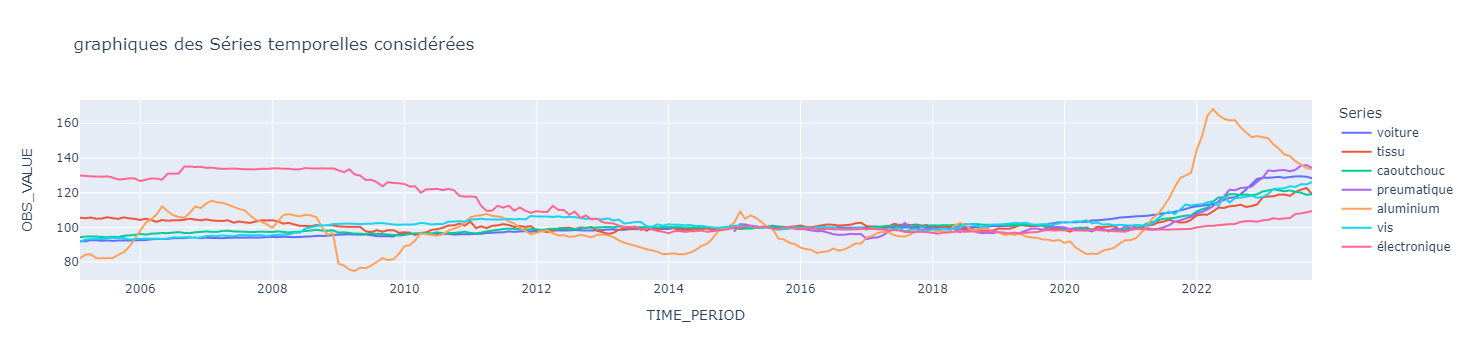

In [76]:
###Importation des nouvelles données
prix_voit = pp.import2('010534366',"voiture")
prix_tissu = pp.import2('010534078',"tissu")
prix_caoutc = pp.import2('010534200',"caoutchouc")
prix_pneum = pp.import2('010534202',"preumatique")
prix_alu = pp.import2('010534272',"aluminium")
prix_vis = pp.import2('010534314',"vis")
prix_electro = pp.import2('010534318',"électronique")

##Graphique des différentes séries ; en cliquant sur les noms des variables sur le graphique, il est possible d'en faire disparaître certaines de façon à simplifier la lecture graphique
data_plot = pd.concat([prix_voit,prix_tissu,prix_caoutc,prix_pneum,prix_alu,prix_vis,prix_electro])
data_plot = data_plot[data_plot.index>"2005-01-31"]
fig = px.line(data_plot, x=data_plot.index, y='OBS_VALUE', color='Series', title = "graphiques des Séries temporelles considérées", hover_data={'OBS_VALUE':':.2f'})
fig.show()

In [77]:
#Construction de la base pour la modélisation : on renomme les variables d'intérêt et on se restreint sur une plage temporelle commune à toutes les séries considérées, à partir de 2005.
prix_voit = pp.sub_rename(prix_voit,"2005-01-31",'voit')
prix_tissu = pp.sub_rename(prix_tissu,"2005-01-31",'tissu')
prix_caoutc = pp.sub_rename(prix_caoutc,"2005-01-31",'caoutc')
prix_pneum = pp.sub_rename(prix_pneum,"2005-01-31",'pneum')
prix_alu = pp.sub_rename(prix_alu,"2005-01-31",'alu')
prix_vis = pp.sub_rename(prix_vis,"2005-01-31",'vis')
prix_electro = pp.sub_rename(prix_electro,"2005-01-31",'elect')

data = pd.merge(prix_voit['voit'],prix_tissu['tissu'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_caoutc['caoutc'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_pneum['pneum'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_alu['alu'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_vis['vis'], on='TIME_PERIOD', how="inner")
data = pd.merge(data,prix_electro['elect'], on='TIME_PERIOD', how="inner")

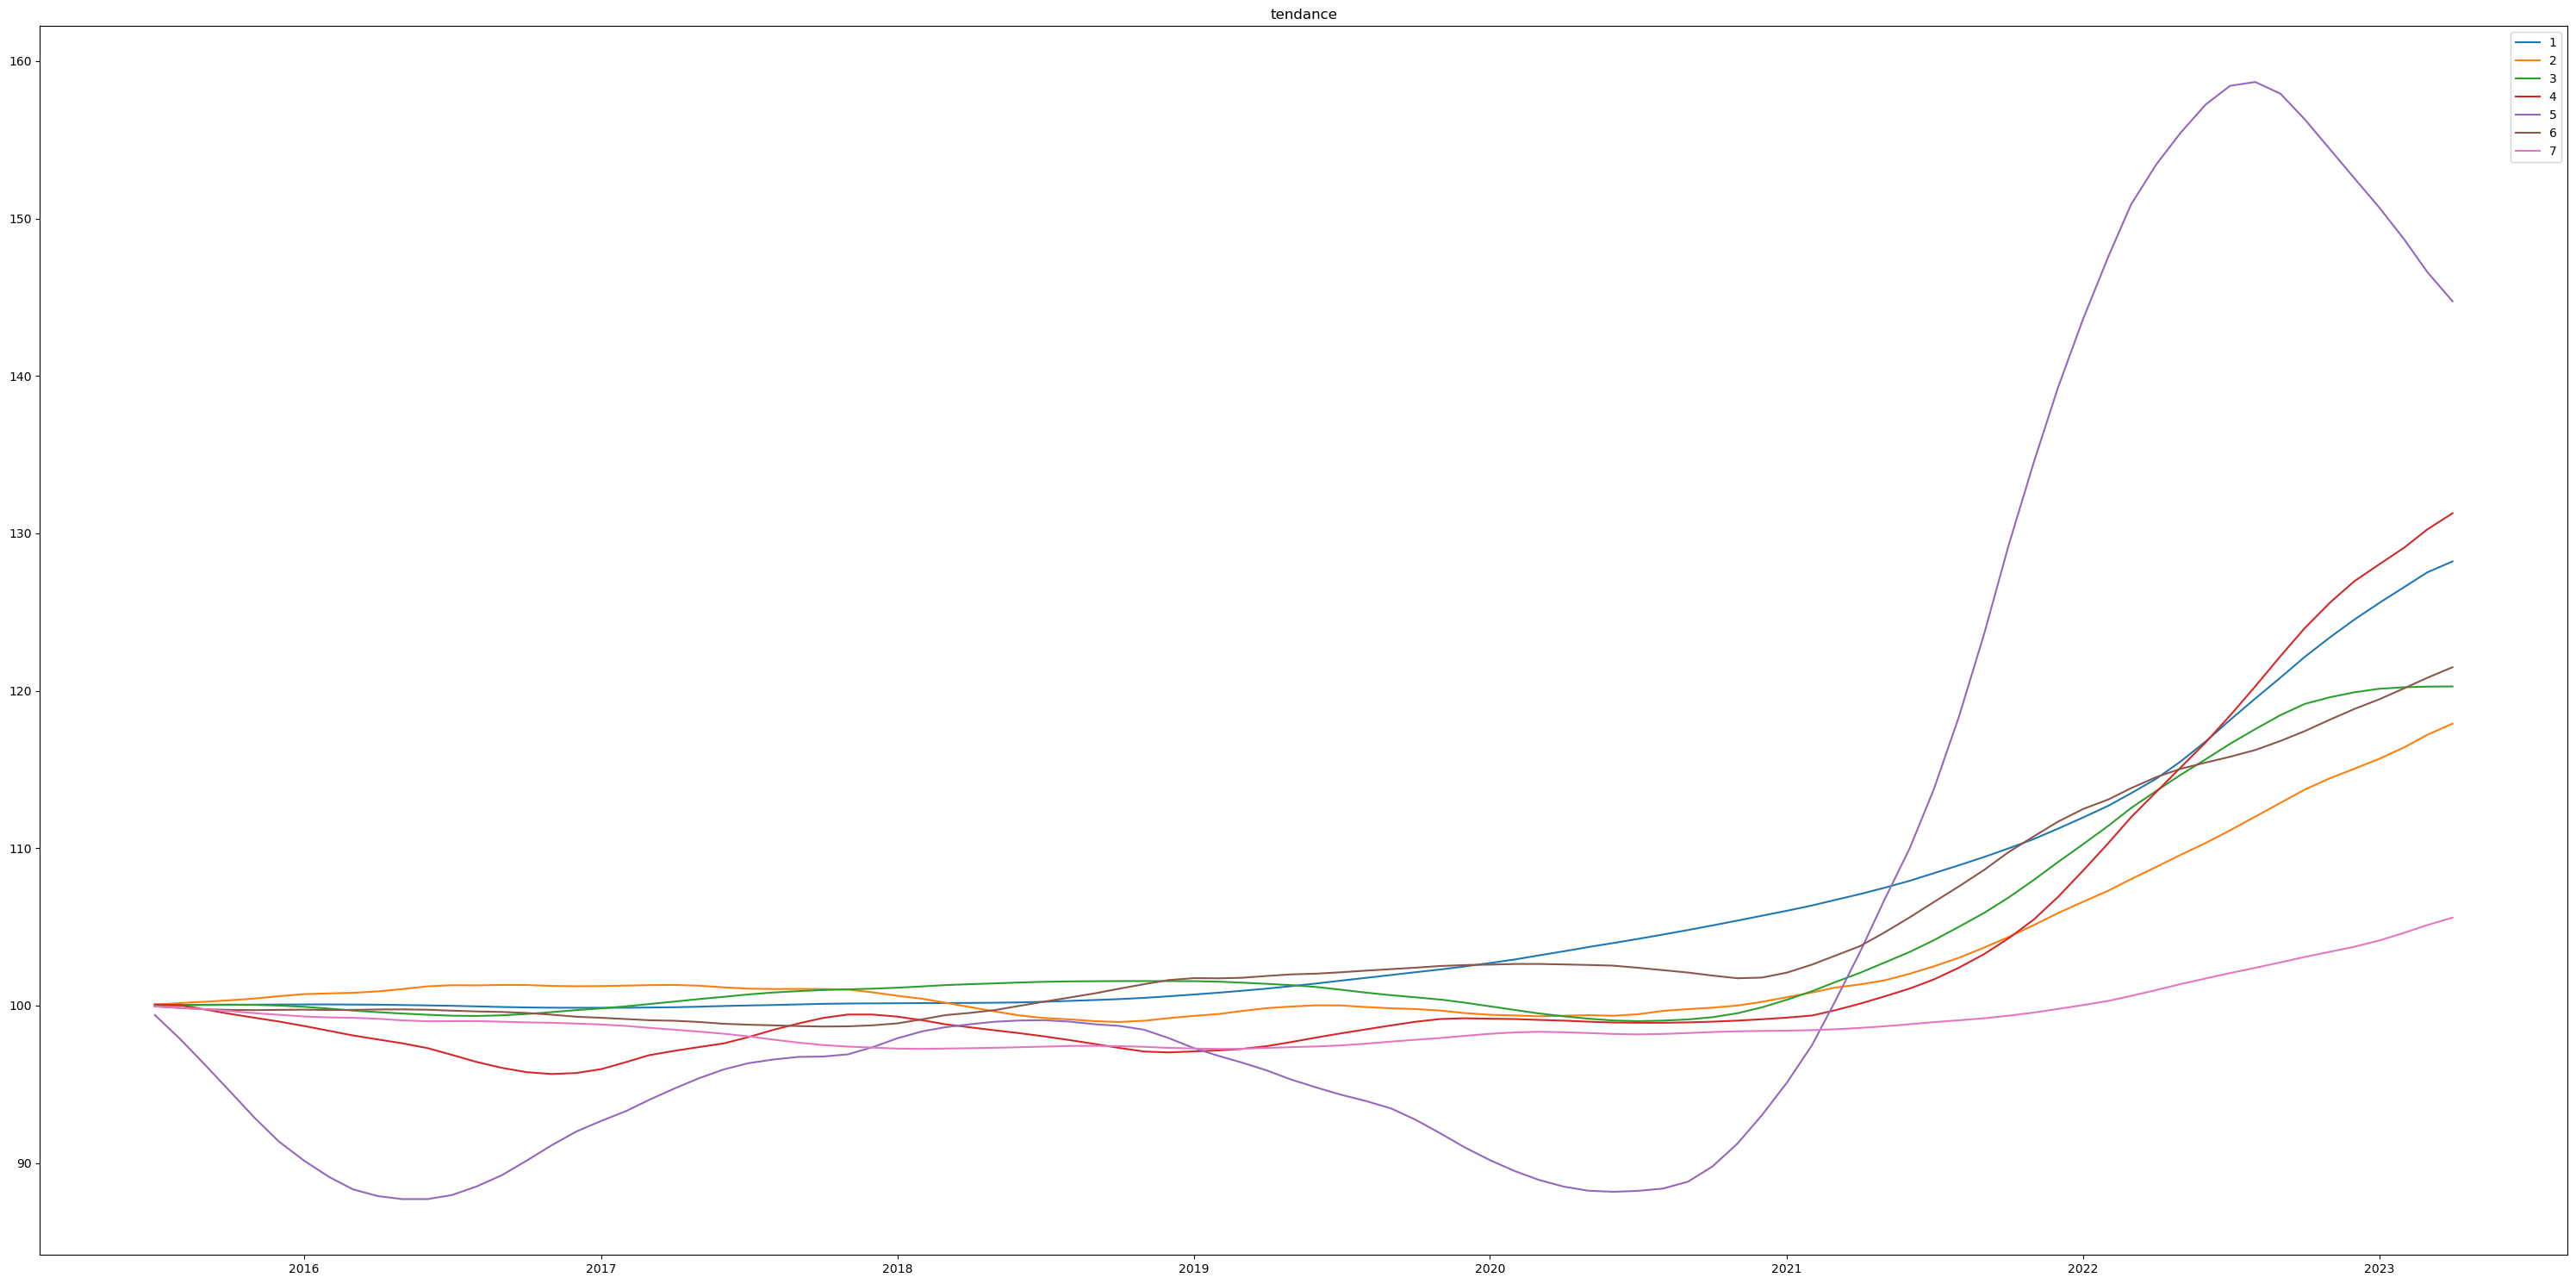

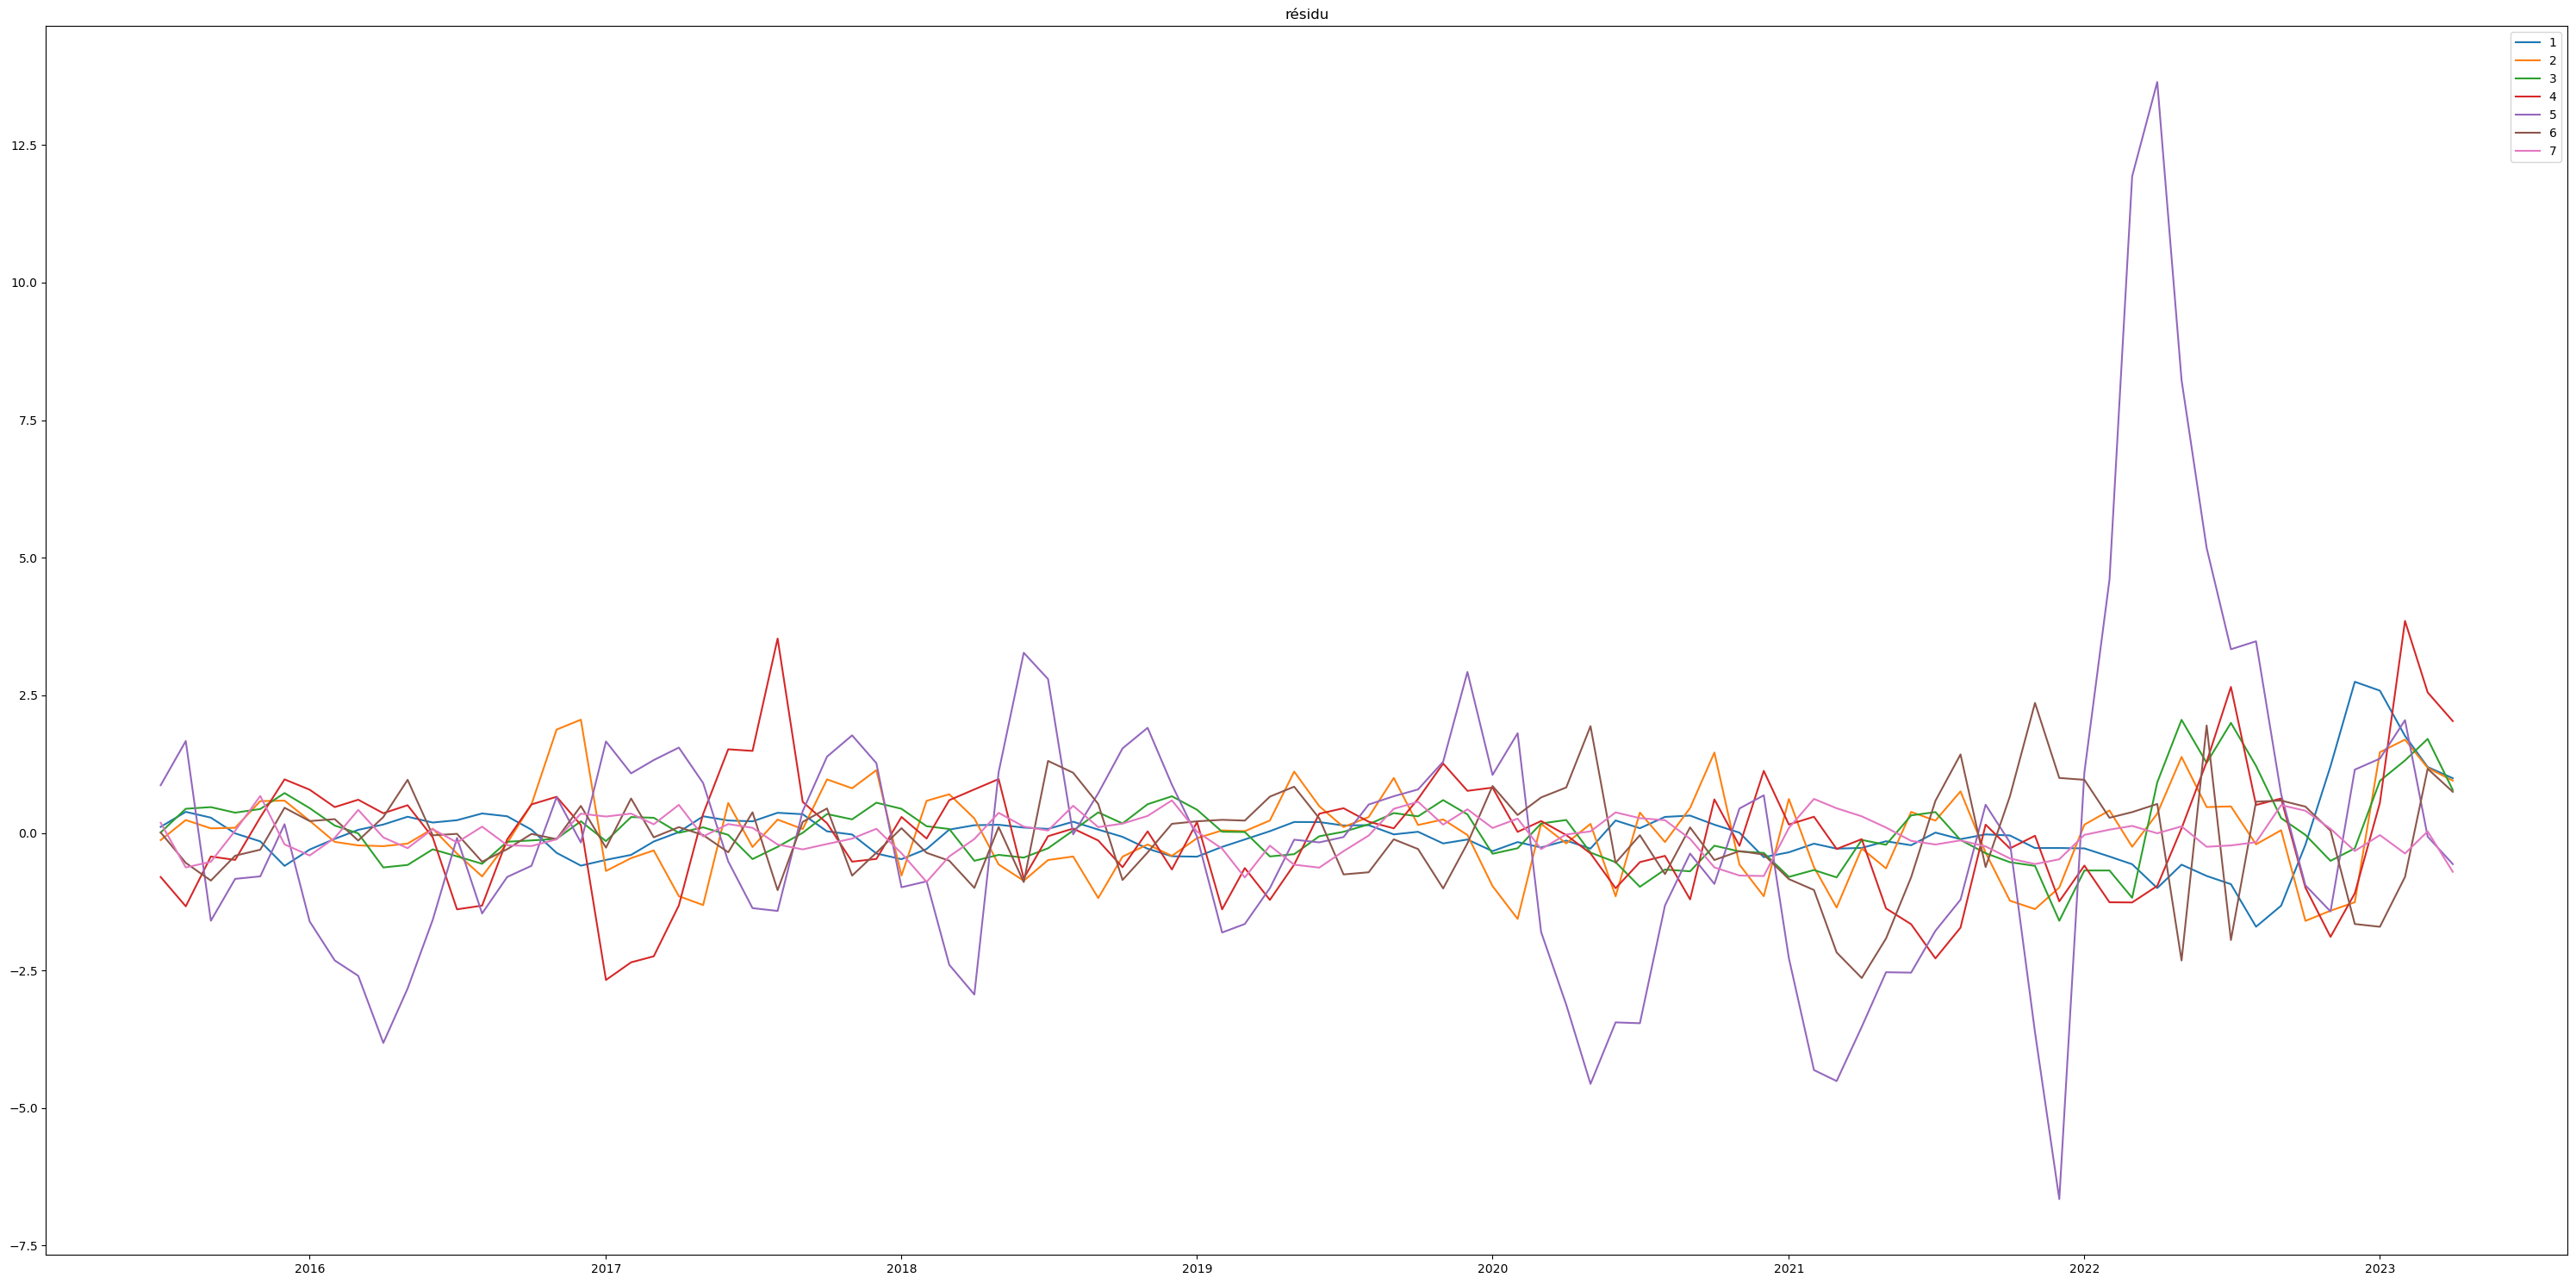

In [91]:
##Décomposition en tendance/saisonnalité/résidu (on regarde surtout la tendance et le résidu)
list_variable = [data['voit'],data['tissu'],data['caoutc'],data['pneum'],data['alu'],data['vis'],data['elect']]
plt.figure(figsize=(30,15))
for i,serie in enumerate(list_variable,1):
    decomposition = seasonal_decompose(serie, model='additive')
    plt.plot(decomposition.trend, label=f'{i}')
    plt.title('tendance')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(30,15))
for i,serie in enumerate(list_variable,1):
    decomposition = seasonal_decompose(serie, model='additive')
    plt.plot(decomposition.resid, label=f'{i}')
    plt.title('résidu')
    plt.legend()
plt.tight_layout()
plt.show()

<Figure size 2500x2500 with 0 Axes>

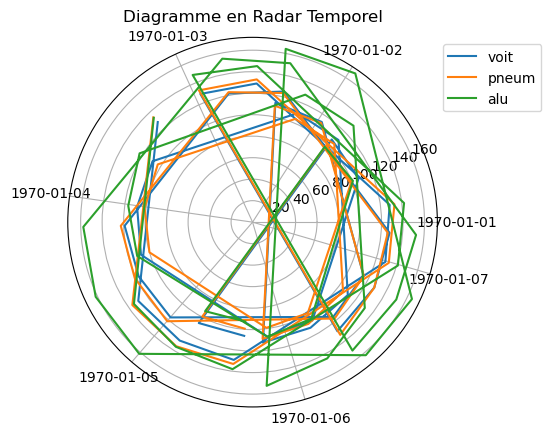

In [92]:
###Quelques autres outils de data-visualisation
##diagramme en radar temporel
data = pd.merge(prix_voit['voit'],prix_tissu['tissu'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_caoutc['caoutc'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_pneum['pneum'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_alu['alu'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_vis['vis'], on=pp.f_time, how="inner")
data = pd.merge(data,prix_electro['elect'], on=pp.f_time, how="inner")
data_sub = data[(data.index>="2021-01-01")]
plt.figure(figsize=(25,25))
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
ax.plot(data_sub['voit'], label='voit')
ax.plot(data_sub['pneum'], label='pneum')
ax.plot(data_sub['alu'], label='alu')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Diagramme en Radar Temporel')
plt.show()

##On observe un fort lien entre ces 3 variables, ce qui va venir renforcer l'idée d'existence d'une relation de co-intégration entre nos différentes variables, 
##et donc on devrait obtenir une équation de long terme avec un processus résiduel stationnaire
##On pouvait déjà observer cela grâce au premier graphique ou à la décomposition en tendance des différentes séries

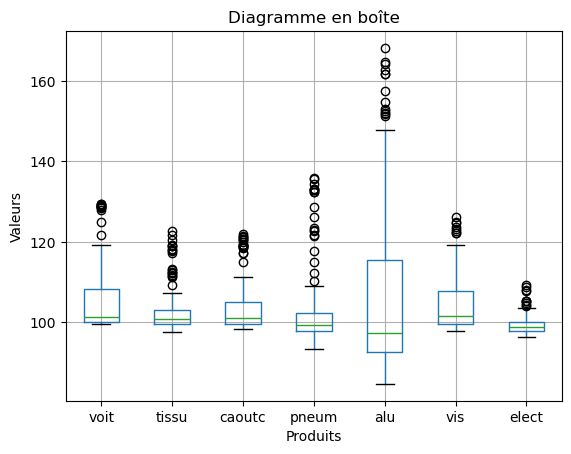

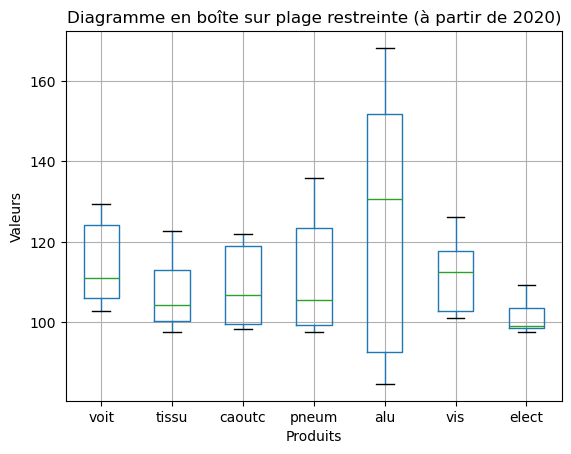

In [93]:
#diagramme en boîte temporel
fig, ax = plt.subplots()
data.boxplot(ax=ax)
ax.set_xlabel('Produits')
ax.set_ylabel('Valeurs')
plt.title('Diagramme en boîte')
plt.show()

##Sur plage temporelle plus restreinte
data_sub = data[(data.index>="2020-01-01")]
fig, ax = plt.subplots()
data_sub.boxplot(ax=ax)
ax.set_xlabel('Produits')
ax.set_ylabel('Valeurs')
plt.title('Diagramme en boîte sur plage restreinte (à partir de 2020)')
plt.show()

Dans un premier temps, nous allons simplement considérer la régression en différences premières sans intégrer la force de rappel issue de la modélisation par ECM. Nous montrerons que cette modélisation "naïve" ne rend pas bien compte des ajustements qui ont lieu en temps de crise, ce que permet justement (en partie du moins) la modélisation par Error Correction Model. Ainsi, dans un second temps, nous étudierons les résultats issus d'une modélisation ECM et nous verrons qu'elle rend mieux compte des chocs dûs à la crise Covid et à la forte inflation qui a suivi. 

In [94]:
###Simple regression sur les variables différenciées
##On vérifie d'abord la stationnarité de ces nouvelles variables

##On différencie les données pour travailler avec des séries stationnaires
data_diff = data.diff().dropna()
##On vérifie la stationnarité des séries utilisées
for i in ['voit','tissu','caoutc','pneum','alu','vis','elect'] :
    test_adf = adfuller(data_diff[i])
    print('p-value ', i,' ', test_adf[1])
##Seul le test de stationnarité sur le tissu est dangereux pour notre analyse, les autres variables donnent des résultats acceptables

p-value  voit   0.005479583355177443
p-value  tissu   0.8247711051732571
p-value  caoutc   0.01539240273249019
p-value  pneum   3.5554034068261476e-05
p-value  alu   0.06285176739552743
p-value  vis   0.046265225564928195
p-value  elect   0.1138091991385361


In [96]:
##Modèle simple avec seulement les différences de premier ordre des séries considérées
X = sm.add_constant(data_diff[['tissu','caoutc','pneum','alu','vis','elect']])
y = data_diff['voit']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.342
Date:                Thu, 21 Dec 2023   Prob (F-statistic):             0.0372
Time:                        08:22:32   Log-Likelihood:                -85.268
No. Observations:                 105   AIC:                             184.5
Df Residuals:                      98   BIC:                             203.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2032      0.060      3.403      0.0

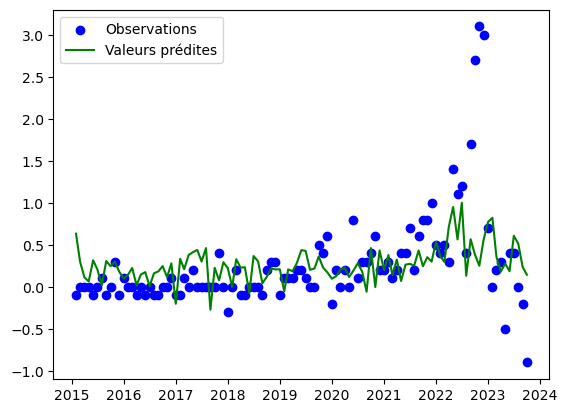

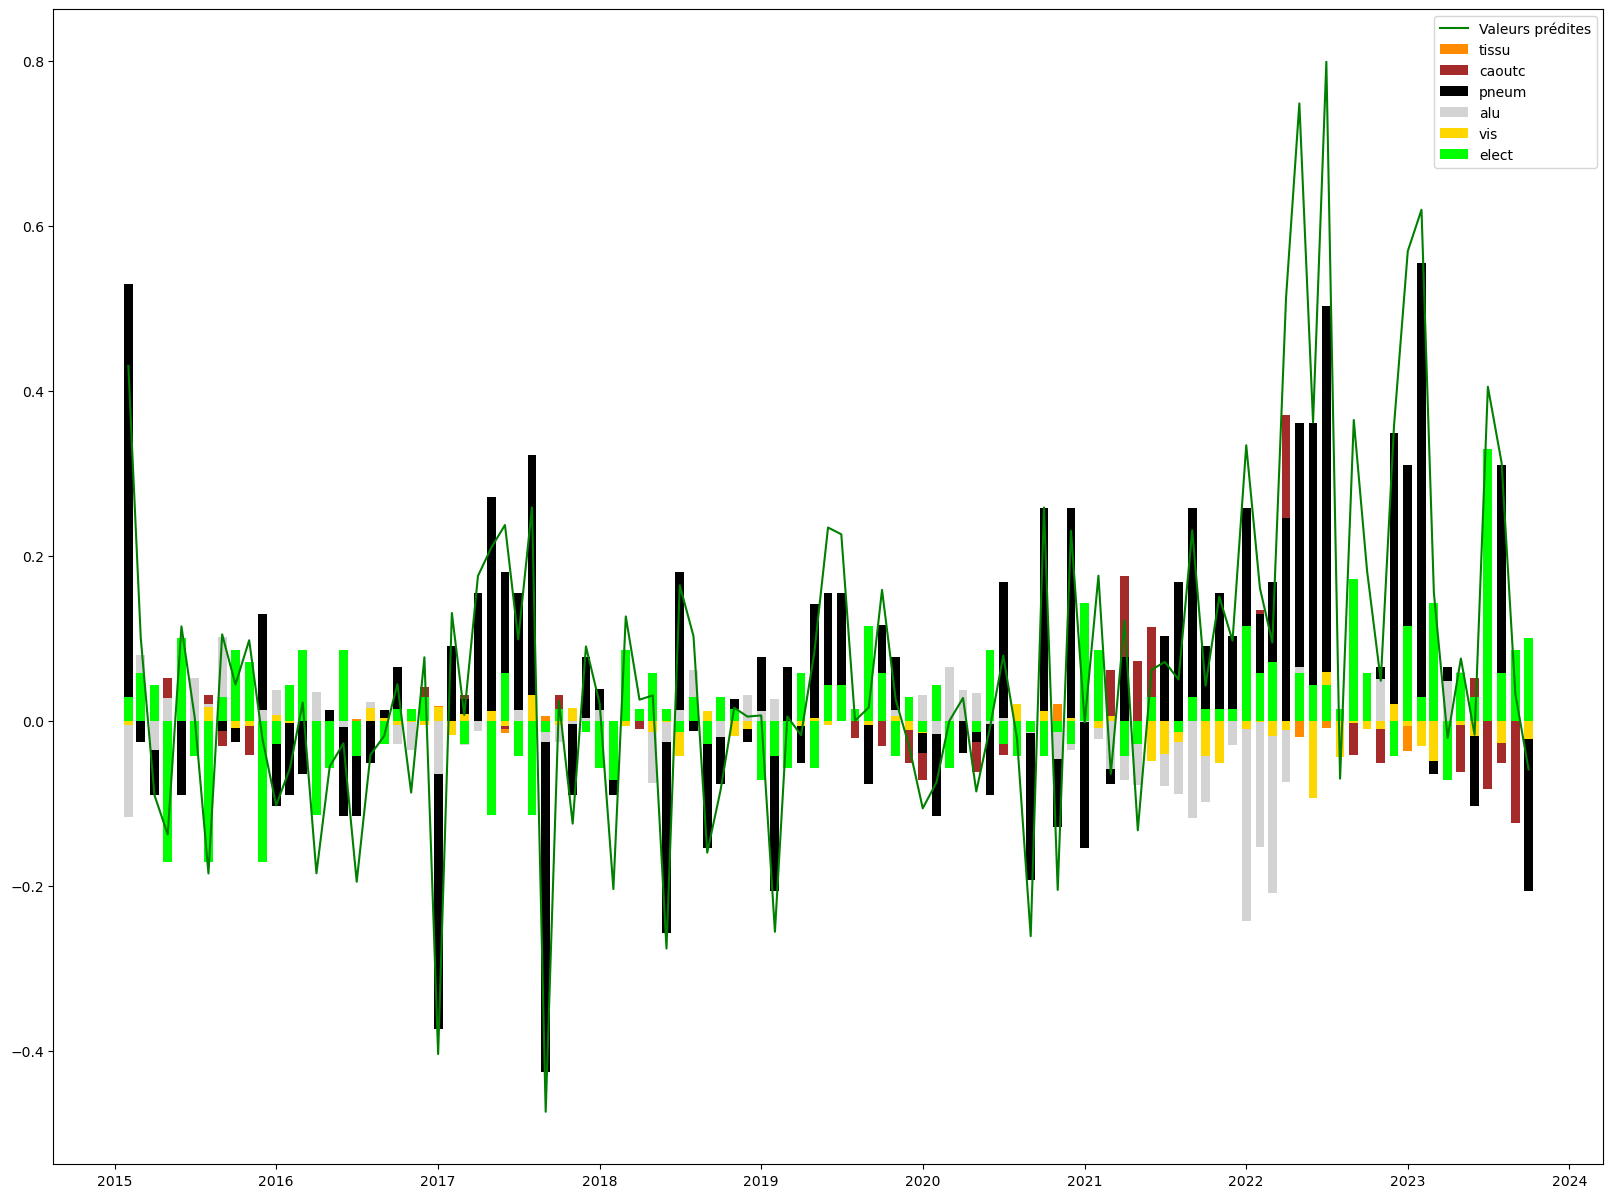

In [97]:
##Outil de visualisation : le premier graphique compare les valeurs prédites par le modèle et les valeurs réelles
##Le second graphique donne la contribution de chaque variables à la valeur prédite finale
contributions = X * results.params
y_pred = results.predict(X)
import matplotlib.pyplot as plt
plt.scatter(X.index,y, label="Observations", color="blue")
plt.plot(X.index, y_pred, label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()


plt.figure(figsize=(20,15))
plt.bar(X.index,contributions['tissu'], label = "tissu", color="darkorange",width=20)
plt.bar(X.index,contributions['caoutc'], label = "caoutc", color="brown",width=20)
plt.bar(X.index,contributions['pneum'], label = "pneum", color="black",width=20)
plt.bar(X.index,contributions['alu'], label = "alu", color="lightgray",width=20)
plt.bar(X.index,contributions['vis'], label = "vis", color="gold",width=20)
plt.bar(X.index,contributions['elect'], label = "elect", color="lime",width=20)
plt.plot(X.index, y_pred-contributions['const'], label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()

##On peut observer qu'en temps de crise (ici on considérera surtout la crise Covid), le modèle n'est pas du tout assez performant pour s'adapter aux chocs.
##On remarquera particulièrement l'écart assez fort sur le premier graphique entre valeurs réelles et prédites à partir de 2022. 

In [100]:
##On peut dès lors voir l'intérêt d'introduire la force de rappel issu d'une équation de long terme, particulièrement adaptée pour modéliser les chocs dus aux crises
##On va donc dans un premier temps rechercher une équation de long terme
##Pour rappel, on doit obtenir un résidu stationnaire à l'issu de cette première étape
##Dans un premier temps on essaie directement la méthode de Stock et Watson
##Pour limiter le biais introduit à la première étape, Stock et Watson propose des dynamic OLS, où on introduit symétriquement des variations avance et retard dans la première étape
data_SW = data
nombre_retard = 2
for j in ['tissu','caoutc','pneum','alu','vis','elect']:
    for i in range(1,nombre_retard+1):
        data_SW[f'Delta_{j}_lag_{i}'] = data_SW[f'{j}']-data_SW[f'{j}'].shift(i)
        data_SW[f'Delta_{j}_lead_{i}'] = data_SW[f'{j}']-data_SW[f'{j}'].shift(-i)
data_SW = data_SW.dropna()
X_SW = data_SW.drop(columns=['voit'])
##Equation de long terme
long_terme = sm.OLS(data_SW['voit'], sm.add_constant(X_SW)).fit()
print(long_terme.summary())

                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     253.2
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           4.56e-61
Time:                        08:26:57   Log-Likelihood:                -129.04
No. Observations:                 102   AIC:                             320.1
Df Residuals:                      71   BIC:                             401.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -47.0639    

In [99]:
residus = long_terme.resid
##test de la stationnarité du résidu estimé en première étape
res_adf = adfuller(residus)
print('p-value',res_adf[1])
##Parfait, le résidu est stationnaire

p-value 0.0005652414210859391


In [101]:
##Equation de court terme
##Attention il faut un peu transformer le résidu avant de l'introduire dans l'équation de court terme (on enlève les effets dus aux variaitions avance et retard des variables explicatives)
residus_trans = data_SW['voit']-np.sum(long_terme.params[['tissu','caoutc','pneum','alu','vis','elect']]*data_SW[['tissu','caoutc','pneum','alu','vis','elect']], axis=1)-long_terme.params['const']
residus_lag = pd.Series(residus_trans.shift(1).dropna(), name='residus')
data_courte = pd.merge(data_diff,residus_lag, on=pp.f_time, how="inner")
X = sm.add_constant(data_courte[['tissu','caoutc','pneum','alu','vis','elect','residus']])
y = data_courte['voit']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
##On observe tout de même une amélioration du R2 ajusté (0.151 contre 0.072)

                            OLS Regression Results                            
Dep. Variable:                   voit   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     3.549
Date:                Thu, 21 Dec 2023   Prob (F-statistic):            0.00200
Time:                        08:27:27   Log-Likelihood:                -76.108
No. Observations:                 101   AIC:                             168.2
Df Residuals:                      93   BIC:                             189.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2222      0.058      3.840      0.0

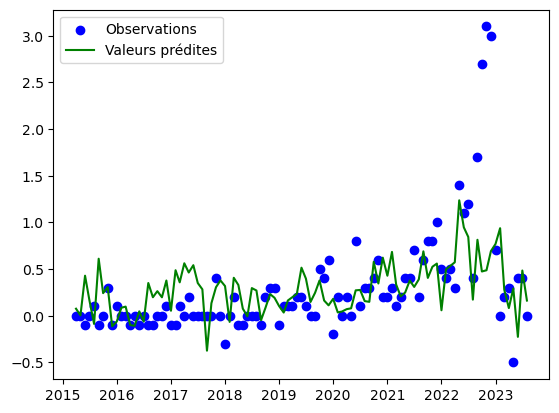

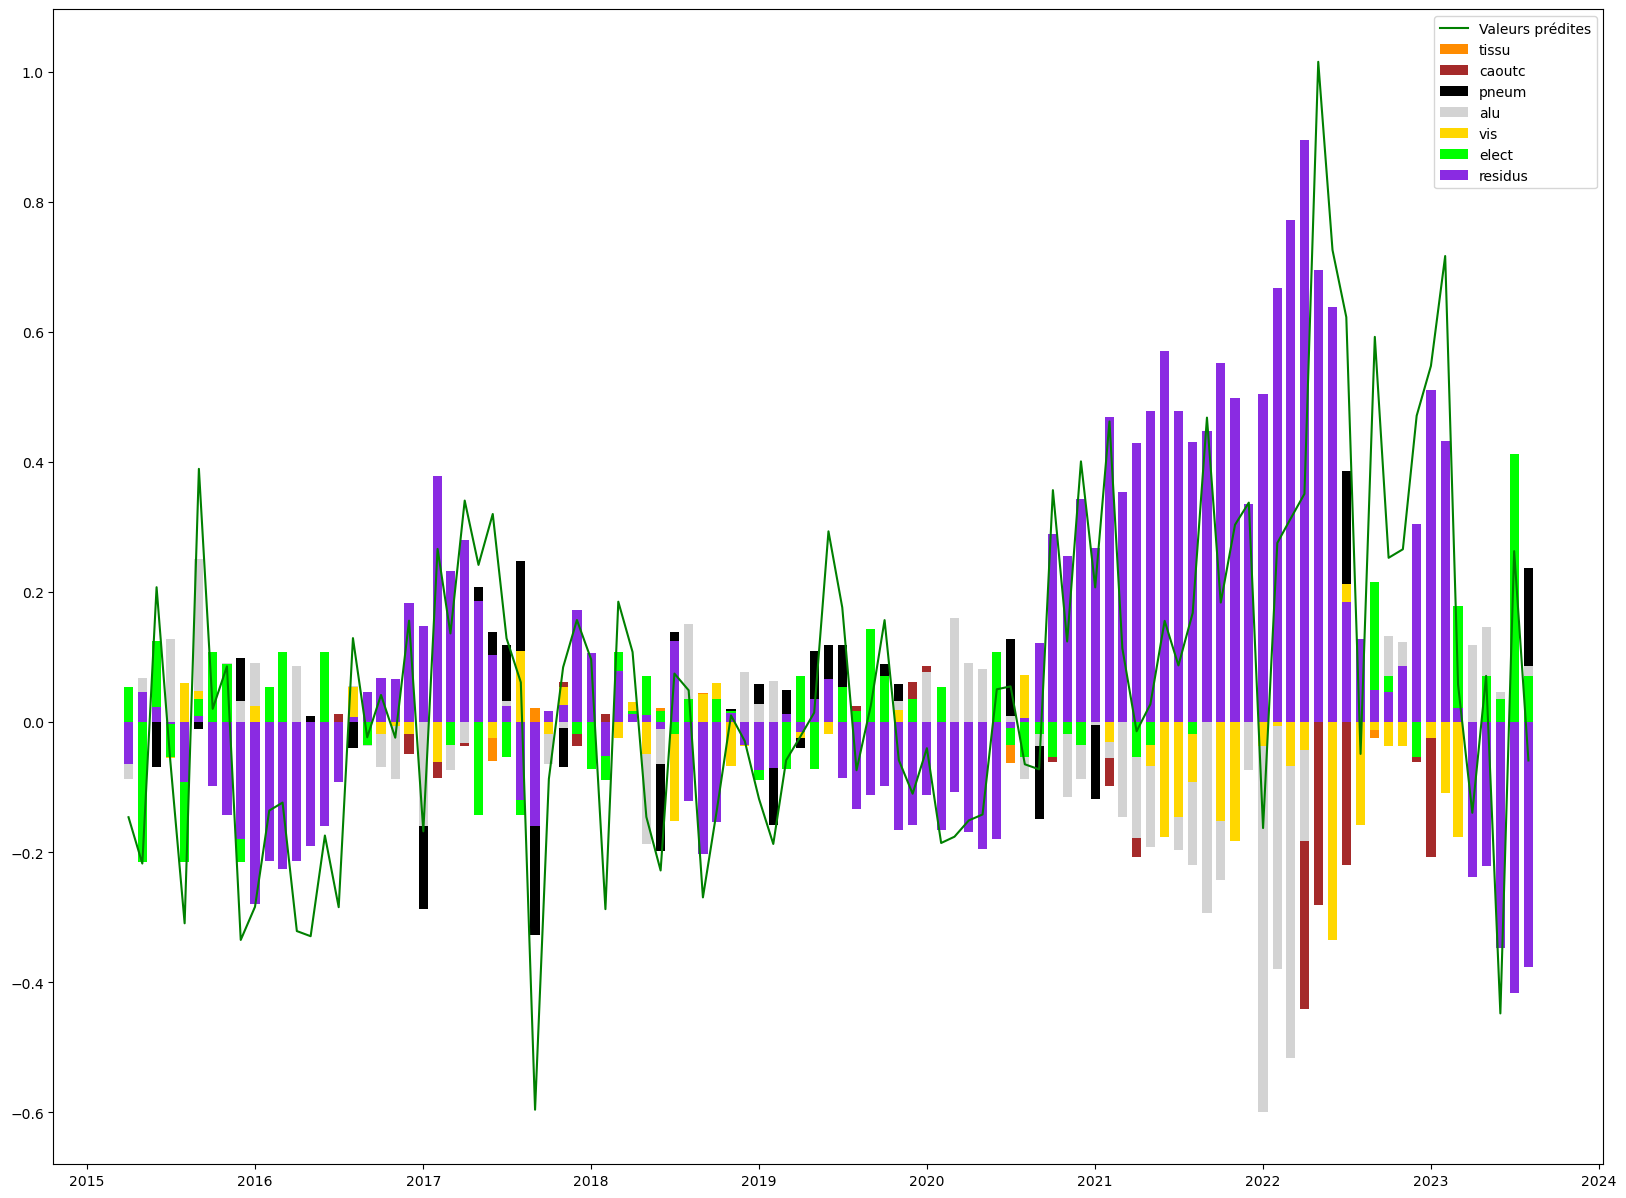

In [102]:
##Outil de visualisation
contributions = X * results.params
y_pred = results.predict(X)
import matplotlib.pyplot as plt
plt.scatter(X.index,y, label="Observations", color="blue")
plt.plot(X.index, y_pred, label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()

plt.figure(figsize=(20,15))
plt.bar(X.index,contributions['tissu'], label = "tissu", color="darkorange",width=20)
plt.bar(X.index,contributions['caoutc'], label = "caoutc", color="brown",width=20)
plt.bar(X.index,contributions['pneum'], label = "pneum", color="black",width=20)
plt.bar(X.index,contributions['alu'], label = "alu", color="lightgray",width=20)
plt.bar(X.index,contributions['vis'], label = "vis", color="gold",width=20)
plt.bar(X.index,contributions['elect'], label = "elect", color="lime",width=20)
plt.bar(X.index,contributions['residus'], label = "residus", color="blueviolet",width=20)
plt.plot(X.index, y_pred-contributions['const'], label = "Valeurs prédites", color = "green")
plt.legend()
plt.show()


##On peut remarquer que le modèle prédit mieux les valeurs problématiques des temps de crise si on regarde le premier graphique
##Par contre, en regardant le second graphique, on peut remarquer que l'introduction de la force de rappel change complètement les contributions des variables explicatives
##Par exemple les coûts en pneumatique perdent de leur importance
##Et à l'inverse, la force de rappel est la variable dominante en période de crise surtout entre 2021 et mi-2022.

# Conclusion

A travers ce projet, nous voulions donner à l'utilisateur quelques clés pour pouvoir étudier rapidement des séries macro-économiques en provenance des instituts statistiques, INSEE ou Eurostat, au travers de statistiques descriptives et de décompositions tendance/saisonnalité/résidus, et proposer un outil de modélisation qui permette de rendre compte des adaptations de l'économie en temps de crise (d'où la "force de rappel").
Nous espérons que cette présentation vous aura plu et vous aura instruit sur les modèles à correction d'erreur et que désormais vous penserez à vérifier la stationnarité des séries avant de les régresser ! ;)




*Nathan VAN ASSCHE et Swann-Emilien MAILLEFERT*